## Social Computing P2
#### By Karan Rakesh (krakesh)
--------
This notebook is aimed at modelling a simulation of the spread of COVID virus and the effect of mitigation strategies at curbing the spread of the virus.

In [26]:
from mesa import Agent, Model
from mesa.batchrunner import BatchRunner
from mesa.time import RandomActivation
from mesa.space import MultiGrid
from mesa.datacollection import DataCollector
from random import sample
import random
import matplotlib.pyplot as plt

# For jupyter notebook add the following line:
%matplotlib inline


### Model Code
----
This section includes the functions essential to running the simulation. It includes:
 - Metrics to be caluclated
 - Model Code
 - Agent code
----
 Inline comments have been added to improve readability

In [27]:
#Quarantine Location
quarantine = (257, 0)

#Metrics Calculation
def compute_infected(model):
    x = 0
    for agent in model.schedule.agents:
        if agent.infected >= 1:
            x+=1
    return x

def compute_cured(model):
    x = 0
    for agent in model.schedule.agents:
        if agent.infected == -1:
            x+=1
    return x

def compute_dead(model):
    x = 0
    for agent in model.schedule.agents:
        if agent.infected == -2:
            x+=1
    return x

def compute_unaffected(model):
    x = 0
    for agent in model.schedule.agents:
        if agent.infected == 0:
            x+=1
    return x

def compute_quarantined(model):
    return model.qcapacity

"""
Parameters of the Model
N: No of Agents, 
width=1 Fixed, 
height=258 Fixed,
inf_percent: Float, Initial percentage of people infected, 
maxcapacity: Int, Upper Limit of people in quarantine centers, 
transPer: Float, Static transmission rate when uninfected person is in proximity of infected person, 
useInfPer: Boolean, Whether to use percentage of infected people in a location to determine transmission rates, 
homeInfection: Boolean, Whether to cause infected people to infect everyone at home with 1.0 probability,

"""
class FinalModel(Model):
    
    def __init__(self, N=1000, width=1, height=258, inf_percent = 0.1, maxcapacity = 100, transPer = 0.5, useInfPer = False, homeInfection = False):
        super().__init__(self,N,width,height)
        self.num_agents = N # Number of agents
        self.grid = MultiGrid(height, width, True) # To allow multiple agents into same location
        self.schedule = RandomActivation(self) #To model real world, we use Random activation 
        self.inf_per = inf_percent #initial percentage of infected people
        self.trans_per = transPer #probability of transmission
        self.qcapacity = 0 # present quarantine capacity
        self.MAX_CAPACITY = maxcapacity #of the quarantine center
        self.USE_INF_PER = useInfPer # Whether to use static transimission rates or vary them by percentage of infected people present
        self.HOME_INFECTION = homeInfection # Whether the infected person spreads the virus to everyone at home with prob 1.0 
        self.datacollector = DataCollector(
            model_reporters={"Infected": compute_infected, "Cured": compute_cured, "Dead": compute_dead, "Quarantined": compute_quarantined})
        
        # Create agents
        random.seed(3) # setting a seed to have fixed set of infected people
        infected_list = sample(range(N), int(self.inf_per*N))
        for i in range(self.num_agents):
            if i in infected_list:
                a = FinalAgent(i, self, 1)
            else:
                a = FinalAgent(i, self)
            self.schedule.add(a)
            # Placing the agents at their respective homes
            x = i//4
            self.grid.place_agent(a, (x, 0))

        self.running = True
        self.datacollector.collect(self)
    
    #Driver Function
    def step(self):
        self.schedule.step()
        # collect data
        self.datacollector.collect(self)

    def run_model(self, n):
        for i in range(n):
            self.step()


class FinalAgent(Agent):

    def __init__(self, unique_id, model, infected_state = 0):
        super().__init__(unique_id, model)
        self.home = unique_id//4
        self.infected = infected_state
        self.infection_prob = 0.1

    def move(self):
        # If out of home, return home
        if self.pos[0] >=250:
            self.model.grid.move_agent(self, (self.home, 0))
        
        movt_choice = self.random.randint(0, 9)
        # Going to a park with p = 0.1
        if movt_choice == 7: 
            movt_choice = self.random.randint(0, 1) #Pick which park
            self.model.grid.move_agent(self, (250 + movt_choice, 0))
        # Going to a grocery with p = 0.2
        elif movt_choice >= 8 :
            movt_choice = self.random.randint(0, 4) #Pick which grocery
            self.model.grid.move_agent(self, (252 + movt_choice, 0))
    
    # Check if any infected people are in same location as agent, return boolean
    def check_infection(self):
        cellmates = self.model.grid.get_cell_list_contents([self.pos])
        noOfInfected = 0
        if i in range(len(cellmates)):
            if cellmates[i].infected > 0:
                noOfInfected += 1
        if self.model.USE_INF_PER:
            self.infection_prob = noOfInfected / len(cellmates)
        if noOfInfected:
            return True
        return False
    
    #Infect all members at home
    def infect_home(self):
        cellmates = self.model.grid.get_cell_list_contents([self.pos])
        if i in range(len(cellmates)):
            if cellmates[i].infected == 0:
                cellmates[i].infected = 1
    
    def infect(self):
        """
        Infected States:
        0 : Unaffected
        1 : Infected Asymptomatic
        2 : Infected Symptomatic
        3 : Critical
        -1: Cured
        -2: Dead
        """
        changestate = self.random.random()
        if self.infected == 0: 
            # Move to Infected Asymptomatic
            if changestate < self.model.trans_per:
                self.infected = 1

        elif self.infected == 1:
            # Move to Infected Symptomatic
            if changestate >= 0.75:
                self.infected = 2

        elif self.infected == 2:
            # Move to quarantine
            if self.random.random() < 0.2 and self.model.qcapacity < self.model.MAX_CAPACITY and self.pos != quarantine:
                self.model.grid.move_agent(self, quarantine)
                self.model.qcapacity += 1
            # To Cure
            if changestate >= 0.75 and changestate < 0.9:
                self.infected = -1
                if self.pos == quarantine:
                    self.model.grid.move_agent(self, (self.home, 0))
                    self.model.qcapacity = self.model.qcapacity - 1
            # To Critical        
            elif changestate >= 0.9 :
                self.infected = 3
        
        elif self.infected == 3:
            # Move to quarantine
            if self.model.qcapacity < self.model.MAX_CAPACITY and self.pos != quarantine:
                self.model.grid.move_agent(self, quarantine)
                self.model.qcapacity += 1
            # To Cure
            if changestate >= 0.75 and changestate < 0.95:
                self.infected = -1
                if self.pos == quarantine:
                    self.model.grid.move_agent(self, (self.home, 0))
                    self.model.qcapacity = self.model.qcapacity - 1
            # To Dead
            elif changestate >= 0.95 :
                self.infected = -2
                if self.pos == quarantine:
                    self.model.grid.move_agent(self, (self.home, 0))
                    self.model.qcapacity = self.model.qcapacity - 1
    
    # Driver Function              
    def step(self):
        #If not in quarantine, agent can move
        if self.pos[0] != 257:
            self.move()
        
        #If agent is not infected, check for infection possibility
        if self.infected == 0:
            if self.check_infection() == True:
                self.infect()
        
        #Else if infected, do    
        elif self.infected > 0:
            # If Home Infection scenario is active and satisfied, infect everybody at home 
            if self.model.HOME_INFECTION and self.pos[0] == self.home:
                self.infect_home()
            self.infect()

### Main Function
----
This section includes the code to run the simulation as per the given parameters in the assignment, though can be modified to incorporate experimental features as well.
 - __useInfPer__ : Boolean, Whether to use percentage of infected people in a location to determine transmission rates
 - __homeInfection__ : Boolean, Whether to cause infected people to infect everyone at home with 1.0 probability

Also includes an output module that takes the three scenarios and displays all the salient features into an easy to understand plot as well as textual format. 
 - The first plot is a trace of the various metrics changing over the course of the simulation. 
 - The second plot is a snapshot of the model at the terminal state, which give key insights into how many people were infected, cured and how many people were safe. 
 - Finally there is also a textual output of the peak values of each of the metrics along with the time step at which they are reached. This helps us determine termination time step, the infection peak and unaffected people.



>>>>> RESULTS FOR INFECTION POPULATION AT 10.0% <<<<<



----------------PART 1 (No Precautions)-----------------
Time Step at which maximum occur
Infected        9
Cured          61
Dead           59
Quarantined     0
dtype: int64

Max Values for each stat
Infected       313
Cured          708
Dead            63
Quarantined      0
dtype: int64
Uninfected :229

----------------PART 2 (w/ Quarantine Centres)-----------------
Time Step at which maximum occur
Infected        8
Cured          55
Dead           50
Quarantined    24
dtype: int64

Max Values for each stat
Infected       218
Cured          634
Dead            56
Quarantined     70
dtype: int64
Uninfected :310

----------------PART 3 (w/ Quarantine Centres and Social Distancing)-----------------
Time Step at which maximum occur
Infected        3
Cured          28
Dead           21
Quarantined     8
dtype: int64

Max Values for each stat
Infected       111
Cured          118
Dead             9
Quarantined     29
dtype: int64
Uni

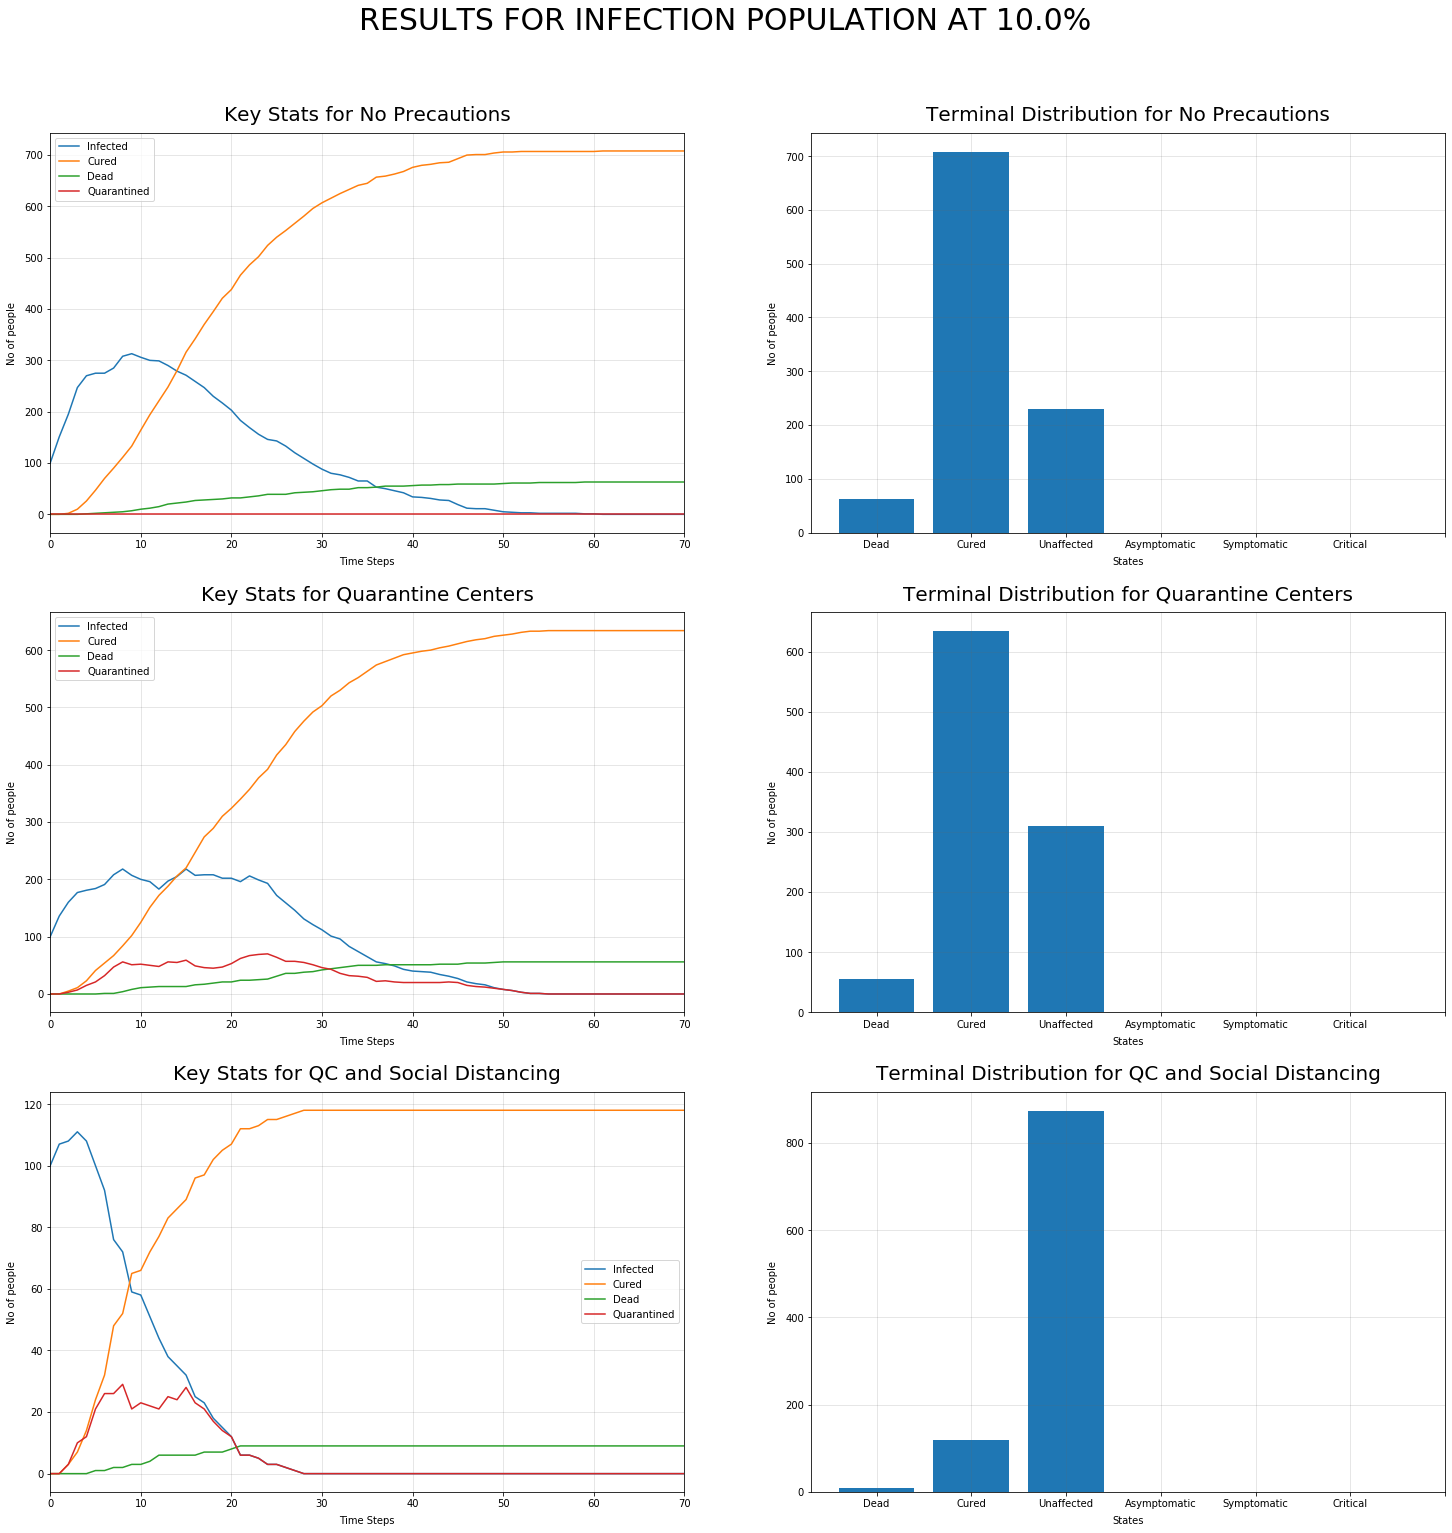

In [31]:
# Please set the infected Percentage here as a decimal value
inf_percentage = 0.1

all_infection = []
all_infection1 = []
all_infection2 = []

"""
Parameters of the Model
N: No of Agents, 
width=1 Fixed, 
height=258 Fixed,
inf_percent: Float, Initial percentage of people infected, 
maxcapacity: Int, Upper Limit of people in quarantine centers, 
transPer: Float, Static transmission rate when uninfected person is in proximity of infected person, 
useInfPer: Boolean, Whether to use percentage of infected people in a location to determine transmission rates, 
homeInfection: Boolean, Whether to cause infected people to infect everyone at home with 1.0 probability,

"""

#This runs the three variants of the model, each model executing 70 steps.

#No precautions, hence quarantine centers do not exist (maxcapacity = 0) and standard transmission rates
Fmodel = FinalModel(N = 1000, inf_percent = inf_percentage,maxcapacity = 0)
for i in range(70):
    Fmodel.step()

#Quarantine Centers, hence maxcapacity = 100 and standard transmission rates
Smodel = FinalModel(N = 1000, inf_percent = inf_percentage,maxcapacity = 100)
for i in range(70):
    Smodel.step()

#Quarantine centers and Social Distancing, hence maxcapacity = 100 and transmission rates have changed accordingly 
Tmodel = FinalModel(N = 1000, inf_percent = inf_percentage,maxcapacity = 100, transPer = 0.1)
for i in range(70):
    Tmodel.step()
    

##### PLOTTING MODULE

fig, ax = plt.subplots(figsize=(25,25),nrows=3, ncols=2)
plt.suptitle("RESULTS FOR INFECTION POPULATION AT "+str(inf_percentage * 100)+"%", y = 0.95, fontsize=30)

print(">>>>> RESULTS FOR INFECTION POPULATION AT "+str(inf_percentage * 100)+"% <<<<<\n\n")
# Store the results FOR FIRST MODEL
FmodelCollector = Fmodel.datacollector.get_model_vars_dataframe()
FmodelCollector.plot(ax=ax[0,0])
ax[0][0].grid(b=True, which='major', color='#666666', linestyle='-', alpha=0.2)
ax[0][0].set_title("Key Stats for No Precautions", y=1.015, fontsize=20)
ax[0][0].set_xlabel("Time Steps", labelpad=7)
ax[0][0].set_ylabel("No of people", labelpad=7)

#plt.show()
print("\n----------------PART 1 (No Precautions)-----------------")
print("Time Step at which maximum occur")
print(FmodelCollector.idxmax())
print("\nMax Values for each stat")
print(FmodelCollector.max())
print("Uninfected :" + str(1000 - FmodelCollector['Dead'].max() - FmodelCollector['Cured'].max() ))

for agent in Fmodel.schedule.agents:
    all_infection.append(agent.infected)

bins_list = [-2,-1, 0, 1, 2, 3, 4]
ax[0][1].hist(all_infection, bins = bins_list, rwidth = 0.8, align='left')
plt.sca(ax[0, 1])
plt.xticks(bins_list, ['Dead','Cured','Unaffected','Asymptomatic','Symptomatic', 'Critical'])
ax[0][1].grid(b=True, which='major', color='#666666', linestyle='-', alpha=0.2)
ax[0][1].set_title("Terminal Distribution for No Precautions", y=1.015, fontsize=20)
ax[0][1].set_xlabel("States", labelpad=7)
ax[0][1].set_ylabel("No of people", labelpad=7)


# Store the results FOR SECOND MODEL
SmodelCollector = Smodel.datacollector.get_model_vars_dataframe()
SmodelCollector.plot(ax = ax[1,0])
ax[1][0].grid(b=True, which='major', color='#666666', linestyle='-', alpha=0.2)
ax[1][0].set_title("Key Stats for Quarantine Centers", y=1.015, fontsize=20)
ax[1][0].set_xlabel("Time Steps", labelpad=7)
ax[1][0].set_ylabel("No of people", labelpad=7)
#plt.show()

print("\n----------------PART 2 (w/ Quarantine Centres)-----------------")
print("Time Step at which maximum occur")
print(SmodelCollector.idxmax())
print("\nMax Values for each stat")
print(SmodelCollector.max())
print("Uninfected :" + str(1000 - SmodelCollector['Dead'].max() - SmodelCollector['Cured'].max() ))

for agent in Smodel.schedule.agents:
    all_infection1.append(agent.infected)

bins_list = [-2,-1, 0, 1, 2, 3, 4]
ax[1][1].hist(all_infection1, bins = bins_list, rwidth = 0.8, align='left')
plt.sca(ax[1, 1])
plt.xticks(bins_list, ['Dead','Cured','Unaffected','Asymptomatic','Symptomatic', 'Critical'])
ax[1][1].grid(b=True, which='major', color='#666666', linestyle='-', alpha=0.2)
ax[1][1].set_title("Terminal Distribution for Quarantine Centers", y=1.015, fontsize=20)
ax[1][1].set_xlabel("States", labelpad=7)
ax[1][1].set_ylabel("No of people", labelpad=7)


# Store the results FOR THIRD MODEL
TmodelCollector = Tmodel.datacollector.get_model_vars_dataframe()
TmodelCollector.plot(ax = ax[2,0])
ax[2][0].grid(b=True, which='major', color='#666666', linestyle='-', alpha=0.2)
ax[2][0].set_title("Key Stats for QC and Social Distancing", y=1.015, fontsize=20)
ax[2][0].set_xlabel("Time Steps", labelpad=7)
ax[2][0].set_ylabel("No of people", labelpad=7)
#plt.show()

print("\n----------------PART 3 (w/ Quarantine Centres and Social Distancing)-----------------")
print("Time Step at which maximum occur")
print(TmodelCollector.idxmax())
print("\nMax Values for each stat")
print(TmodelCollector.max())
print("Uninfected :" + str(1000 - TmodelCollector['Dead'].max() - TmodelCollector['Cured'].max() ))

for agent in Tmodel.schedule.agents:
    all_infection2.append(agent.infected)

bins_list = [-2,-1, 0, 1, 2, 3, 4]
ax[2][1].hist(all_infection2, bins = bins_list, rwidth = 0.8, align='left')
plt.sca(ax[2, 1])
plt.xticks(bins_list, ['Dead','Cured','Unaffected','Asymptomatic','Symptomatic', 'Critical'])
ax[2][1].grid(b=True, which='major', color='#666666', linestyle='-', alpha=0.2)
ax[2][1].set_title("Terminal Distribution for QC and Social Distancing", y=1.015, fontsize=20)
ax[2][1].set_xlabel("States", labelpad=7)
ax[2][1].set_ylabel("No of people", labelpad=7)

# Display and store the results
plt.savefig('comboplot_'+str(inf_percentage)+'.png', dpi= 72)
plt.show()

